In [90]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import GroupShuffleSplit

from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

from matplotlib.collections import LineCollection

sns.set('notebook', style='whitegrid', font_scale=1.3)

# Cross-validaion


### train_test_split ###

При оценке качества модели нельзя использовать данные, которые использовались для ее обучения, т.к. при таком подходе мы не сможем оценить адекватность модели на новых данных и контролировать переобучение. Для решения данной проблемы существуют подходы, использующие понятие **отложенной выборки**: $X_{test}$, $Y_{test}$. Отложенной выборкой называют размеченные данные, которые мы не используем при обучении модели. В scikit-learn разбиение на обучающую и тестовую выборки можно легко получить с помощью функции `train_test_split`. Рассмотрим на примере.

In [17]:
# загружаем датасет 
data_full = datasets.load_iris()
print("Shape: {}".format(data_full.data.shape))

Shape: (150, 4)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    # *arrays: принимает индексируемые объекты с совпадающей shape[0]. 
    # Например: list, np.array, pd.DataFrame.
    data_full.data, data_full.target,
    test_size=0.4,  # доля данных, которые берем в тестовую выборку
    random_state=0,  # фиксируем случайность
    shuffle=True,  # перемешивает данные в случайном порядке 
    stratify=None  # если не None, то сохраняет доли классов при разбиении
)

In [19]:
print("Shape of train data: {} {}".format(X_train.shape, y_train.shape))
print("Shape of test data: {} {}".format(X_test.shape, y_test.shape))

Shape of train data: (90, 4) (90,)
Shape of test data: (60, 4) (60,)


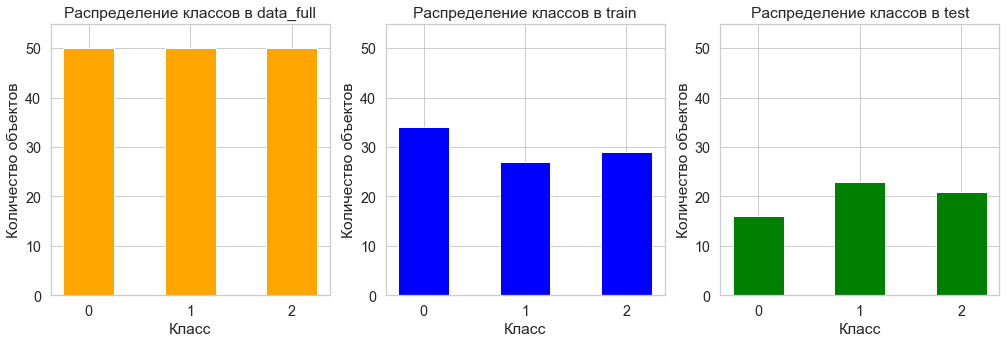

In [20]:
plt.figure(figsize=(17,5))
split_cases = [data_full.target, y_train, y_test]
colors = ['orange', 'blue', 'green']
labels = ['Распределение классов в data_full', 
          'Распределение классов в train', 
          'Распределение классов в test']
for i in range(3):
    plt.subplot(1, 3, i + 1)
    values, counts = np.unique(split_cases[i], return_counts=True)
    plt.bar(values, counts, width=0.5, color=colors[i])
    plt.ylim(0, 55)
    plt.xticks([0, 1, 2])
    plt.xlabel('Класс')
    plt.ylabel('Количество объектов')
    plt.title(labels[i])
plt.show()

Теперь попробуем сделать разбиение с `stratify = data_full.target`. Стратификация - стратегия кросс-валидации, при которой в обучающей и тестовой выборке сохраняется одинаковое распределение целевой переменной (такое же, как во всем датасете). Зачем нужна стратификация узнаем чуть позже.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    # *arrays: принимает индексируемые объекты с совпадающей shape[0]. 
    # Например: list, np.array, pd.DataFrame.
    data_full.data, data_full.target,
    test_size=0.4, # доля данных, которые берем в тестовую выборку
    random_state=0, # фиксируем случайность
    shuffle=True, # перемешивает данные в случайном порядке 
    # сохраняем доли классов при разбиении как в таргете
    stratify=data_full.target
)

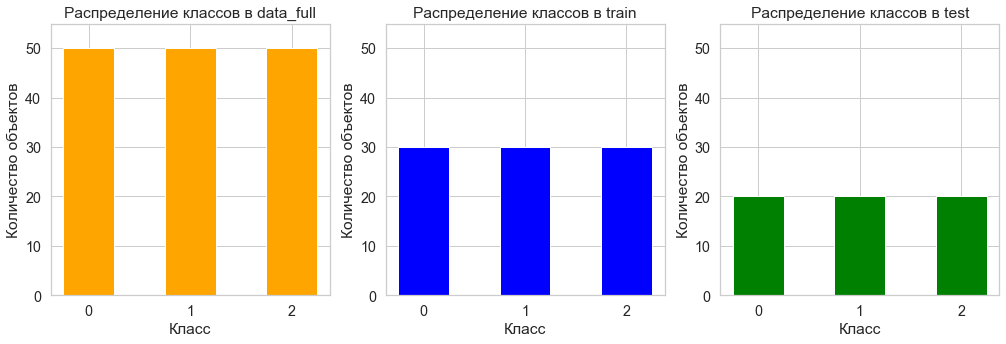

In [22]:
plt.figure(figsize = (17,5))
split_cases = [data_full.target, y_train, y_test]
colors = ['orange', 'blue', 'green']
labels = ['Распределение классов в data_full', 
          'Распределение классов в train', 
          'Распределение классов в test']
for i in range(3):
    plt.subplot(1, 3, i + 1)
    values, counts = np.unique(split_cases[i], return_counts=True)
    plt.bar(values, counts, width=0.5, color=colors[i])
    plt.ylim(0, 55)
    plt.xticks([0, 1, 2])
    plt.xlabel('Класс')
    plt.ylabel('Количество объектов')
    plt.title(labels[i])
plt.show()

Видим, что после разбиения с `stratify = data_full.target` распределения классов в train и test не отличаются. 

**Достоинства:**
* быстрый для оценки качества модели. При использовании данной техники разбиения данных для оценки качества модели происходит одна процедура обучения на обучающей выборке, после чего качество модели оценивается на тестовых данных. 

**Недостатки:**
* результат сильно зависит от способа разбиения. Объекты в train и test могут получиться из разных распределений, если `stratify = False`.
* при обучении модели на обучающей выборке тестовая выборка не используется, то есть мы не задействуем все доступные данные для обучения.
* при оптимизации значения метрики на тестовом множестве модель немного переобучается под тестовое множество. Таким образом, значение метрики качества на новых данных не будет соответствовать значению метрики на тестовом множестве.

### k-Fold Cross Validation ###

Описанные выше недостатки оказались критичны, поэтому для борьбы с ними придумали кросс-валидацию. **Кросс-валидация** - это метод оценки качества модели, при котором обучающая выборка делится на $k$ частей, или **фолдов**. После чего для каждого из $k$ фолдов проделывается следующая процедура: 
* модель обучается на остальных $k-1$ фолдах, которые вместе формируют обучающую выборку для данной итерации
* обученная модель оценивается на оставшемся $k$-ом фолде  

Таким образом мы получаем $k$ оценок качества. Итоговая метрика считается как среднее полученных оценок. Ниже представлена визуализация рассматриваемой стратегии кросс-валидации для пяти фолдов. 

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="40%">

Рассмотрим пример. Будем использовать данные о ценах квартир в Бостоне.

In [23]:
boston = datasets.load_boston() # данные о ценах квартир в Бостоне
X = pd.DataFrame(data=boston['data'], columns= boston['feature_names'])
y = boston['target']

Описание датасета.

In [24]:
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [25]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [26]:
X.shape

(506, 13)

In [27]:
model = LinearRegression()
scores = cross_val_score(
    estimator=model, # модель, качество которой хотим оценить
    X=X, # данные для обучения (не содержат целевую переменную)
    y=y, # значения целевой переменной
    cv=5, # количество фолдов
    scoring='neg_mean_squared_error', # метрика качества
    n_jobs=-1 # количество ядер для вычислений, -1 - использование всех ядер
)

Стоит отметить, что в качестве scroing мы используем `neg_mean_squared_error`. Префикс neg показывает, что мы оптимизируем $(-1) \cdot MSE$. Дело в том, что оптимизации в sklearn подразумевают **максимизацию** метрики качества.

Посмотрим на распределение цен, чтобы понимать в каком масштабе находятся значения MSE. 

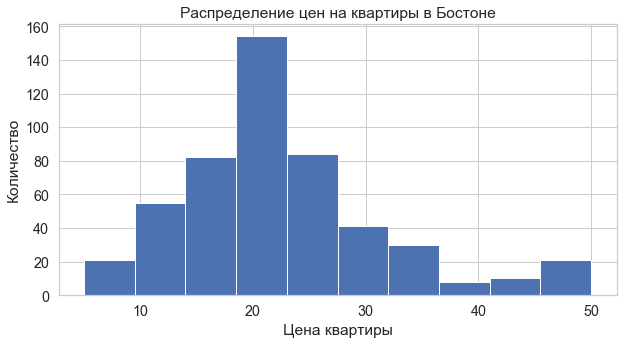

In [28]:
plt.figure(figsize=(10,5))
plt.hist(y)
plt.xlabel('Цена квартиры')
plt.ylabel('Количество')
plt.title('Распределение цен на квартиры в Бостоне')
plt.show()

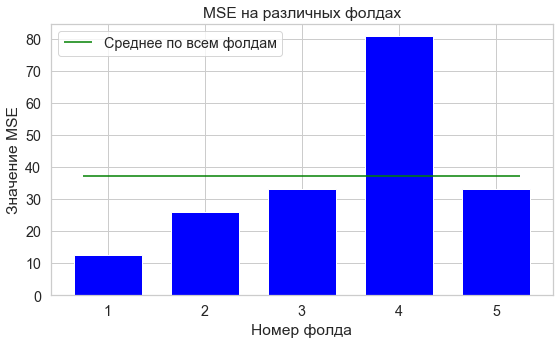

In [33]:
plt.figure(figsize=(9,5))
plt.bar(range(1, 6), (-1)*scores, width=0.7, color='blue')
plt.hlines(np.mean((-1)*scores), 0.75, 5.25, color='green', 
           label='Среднее по всем фолдам')
plt.xlabel('Номер фолда')
plt.ylabel('Значение MSE')
plt.title('MSE на различных фолдах')
plt.legend()
plt.show()

Полезно знать:  
* [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) - позволяет задать сразу несколько метрик для подсчета качества модели. Возвращаем значения данных метрик для каждой итерации кросс-валидации в виде словаря.
* [`cross_val_predict`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict) - возвращает предсказания, полученные для каждого объекта выборки при кросс-валидации.

Выше мы рассмотрели функцию `cross_val_score`, которая имеет аргумент `cv`. По умолчанию данный аргумент использует KFold, но ему можно передавать и другие стратегии кросс-валидации. Рассмотрим аналогичный способ использования KFold Cross Validation, который на практике является более гибким. 

In [34]:
kf = KFold(
    n_splits=2,  # количество фолдов 
    shuffle=False  # перемешиваем ли данные перед разбиением
)
kf

KFold(n_splits=2, random_state=None, shuffle=False)

В sklearn объекты классов, которые соответствуют стратегиям кросс-валидации, обычно имеют два метода:
* `get_n_splits` - возвращает количество итераций, которое необходимо для заданной стратегии кросс-валидации
* `split` - возвращает генератор индексов для разбиения данных на train и test 

In [52]:
kf.get_n_splits()

2

In [36]:
kf.split(
    X=X  # данные для разбиения
)

<generator object _BaseKFold.split at 0x1a24085650>

Приведем пример, демонстрирующий работу метода `split`.

In [37]:
data = np.array([[81, 27], [26, 45], [83, 64], [25, 98]])
data

array([[81, 27],
       [26, 45],
       [83, 64],
       [25, 98]])

In [38]:
for train_index, test_index in kf.split(data):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1] TEST: [2 3]


Случай, когда аргумент `cv` функции `cross_val_score` принимает на вход стратегию кросс-валидации. На выходе функции получаем значения метрик для каждой итерации кросс-валидации.

In [39]:
scores = cross_val_score(estimator=model, X=X, y=y, cv=kf, 
                         scoring='neg_mean_squared_error')
scores

array([ -27.21869349, -303.43686293])

Визуальная интерпретация KFold Cross Validation:  
![kFold](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_002.png)



На данном графике представлена 4-Fold CV (сокращение от Cross-Validation). Каждую горизонтальную полосу стоит понимать как одну и ту же выборку из 100 элементов. По горизонтальной оси показан номер элемента выборки. По вертикальной оси сверху отложены номера фолдов. Снизу отложены разбиения выборки по классу (целевая переменная) и какому-то категориальному признаку (группа). О группах будет сказано чуть позже.

**Достоинства:**  
* оценивается качество модели, полученное при обучении на всех данных.  
* при подборе гиперпараметров можем контролировать переобучение, т.к. выбирается модель, показавшая лучшее качество на отложенных (тестовых) фолдах. Переобучение - это ситуация, когда модель показывает хорошее качество на обучающей выборке, но плохое качество на отложенной выборке.


**Недостатки:**
* значительная вычислительная сложность. Вместо одной процедуры обучения приходится обучать модель k раз. 
* никак не учитывает распределение значений целевой переменной.
* не учитывает разбиение объектов на группы (что это такое разберемся чуть ниже).

### Leave One Out (LOO)

Данная стратегия кросс-валидации по сути является NFold CV, где $N$ - количество элементов в обучающей выборке. На каждой итерации мы обучаем модель на $N - 1$ элементах и оцениваем качество на оставшемся элементе. 


In [56]:
X = [1, 2, 3, 4]
loo = LeaveOneOut()

# итерируемся по разбиениям множества индексов
for train, test in loo.split(X):
    print("%s %s" % (train, test))

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


**Достоинства:**  
* на каждой итерации при обучении модели используются все данные, за исключением одного элемента.  
* исследование отдельных объектов. Если на каком-то объекте допускается большая ошибка, может это выброс.
* в некоторых случаях выведены теоретические формулы результата LOO. 

**Недостатки:**  
* огромная вычислительная сложность, не рекомендуется использовать на больших данных.
* модель, полученная на конкретной итерации, не сильно отличается от моделей, которые получены на других итерациях. Таким образом ошибка сильно зависит от отложенного элемента, вследствие чего среди ошибок на отложенных элементах можно наблюдать высокий разброс.

### LeavePOut ###

Данная стратегия кросс-валидации заключается в следующем. Пусть $n$ - размер выборки. При $p=1$ данная стратегия эквивалентна LOO. Важно понимать, что `LeavePOut(p)` не является `KFold(n_splits=n_samples // p)`, т.к. KFold создает непересекающиеся тестовые множества. Для оценки модели будет обучено $C_n^p$ моделей, где на каждой итерации для обучающей выборки будет взято $n-p$ элементов, а для тестовой $p$ элементов. Пример использования:

In [41]:
X = [0.76, 0.43, 0.47, 0.82, 0.22]  # какая-то выборка размера 5
lpo = LeavePOut(p=2)  # p - количество элементов в отложенном фолде
for train, test in lpo.split(X):
     print("%s %s" % (train, test))

[2 3 4] [0 1]
[1 3 4] [0 2]
[1 2 4] [0 3]
[1 2 3] [0 4]
[0 3 4] [1 2]
[0 2 4] [1 3]
[0 2 3] [1 4]
[0 1 4] [2 3]
[0 1 3] [2 4]
[0 1 2] [3 4]


**Достоинства:**  
* является *исчерпывающей* стратегией кросс-валидации для заданного размера тестовой выборки, т.е. проверяет все возможные способы разделения исходной выборки на обучающее и тестовое множества заданного размера.  

**Недостатки:**  
* огромная вычислительная сложность, которая быстро растет с увеличением параметра $p$. Не рекомендуется использовать на больших данных. Например, при n=100 и p=30 необходимо обучить примерно $3 \cdot 10^{25}$ моделей.
* на некоторых итерациях распределение целевой переменной в обучающей и тестовой выборке может быть слишком разным (нет стратификации)

### ShuffleSplit ###

Данная стратегия состоит в следующем:  
* фиксируем количество итераций `n_splits`, т.е количество разбиений, которое мы хотим получить. 
* фиксируем размер тестовой выборки `test_size`, который будет одинаковым на каждой итерации.  
* перемешиваем выборку и делим ее на две части: train и test. Проделываем это `n_splits` раз. 

Пример работы:

In [42]:
X = np.arange(10)  # какая-то выборка размера 10
ss = ShuffleSplit(
    # количество итераций перемешивания с разбиением на train и test
    n_splits=5,
    # доля объектов, которые хотим класть в test на каждой итерации
    test_size=0.25,
    random_state=0
)

for train_index, test_index in ss.split(X):
    print("%s %s" % (train_index, test_index))

[9 1 6 7 3 0 5] [2 8 4]
[2 9 8 0 6 7 4] [3 5 1]
[4 5 1 0 6 9 7] [2 3 8]
[2 7 5 8 0 3 4] [6 1 9]
[4 1 0 6 8 9 3] [5 2 7]


Визуальная интерпретация: 

![ ShuffleSplit ](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0061.png)

**Достоинства:**  
* является хорошей альтернативой KFold, т.к. дает более четкий контроль над количеством итераций и разбиением на train и test. 

**Недостатки:**  
* на некоторых итерациях распределение целевой переменной в обучающей и тестовой выборке может быть слишком разным, так как разбиение случайно.
* не учитывает разбиение объектов на группы (что это такое разберемся чуть ниже).

**ВАЖНО:** ключевым отличием KFold от ShuffleSplit является тот факт, что в KFold каждый объект выборки в одной из итераций попадает в тестовый фолд, а в остальных итерациях используется для обучения. В ShuffleSplit разбиение каждой итерации не зависит от предыдущих итераций, объект выборки может как попасть в тестовый фолд, так и не попасть.

### Stratified KFold (Только для классификации) ###

При рассмотрении различных стратегий кросс-валидации выше мы неоднократно отмечали, что многие стратегии не учитывают распределение целевой переменной. В некоторых задачах это может быть критично. Например, если вам нужно будет предсказать вероятность заболевания у пациента, то в выборке наверняка будет сильный дисбаланс классов. Таким образом при кросс-валидации объекты выборки из положительного класса могут просто не попасть в фолды для обучения. Для решения данной проблемы используется Stratified KFold. При таком подходе каждый фолд имеет примерно такое же распределение целевого класса, как и во всем датасете. Это нужно, т.к. мы хотим получить значение метрики, которая отражает *реальное* качество модели, а значение метрики сильно зависит от баланса классов. Например, модель, предсказывающая для всего класс $0$, будет иметь хорошее качество на множестве $0, 0, 1, 0$, но плохое на $1, 1, 1, 0$. Сохраняя баланс классов, нам удасться получить значение метрики, которое более приближено к реальному качеству модели. 

Рассмотрим применение Stratified KFold к задаче классификации ирисов. Построим графики распределения классов на каждой итерации.

In [63]:
iris = datasets.load_iris()
X = pd.DataFrame(data=iris['data'], columns=iris['feature_names'])
y = iris['target']

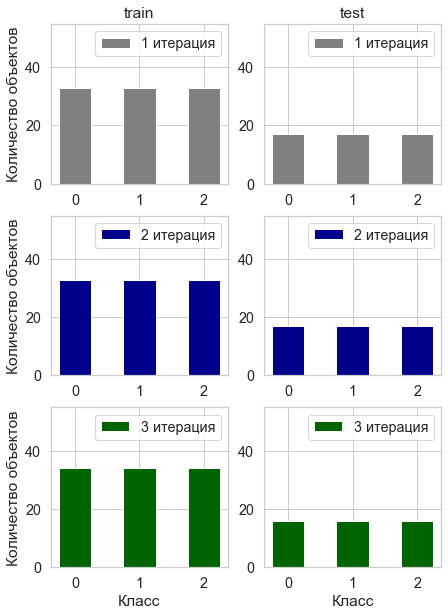

In [64]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

colors = ['grey', 'darkblue', 'darkgreen']

plt.figure(figsize=(7, 10))
for i, (train, test) in enumerate(skf.split(X, y)):
    plt.subplot(3,2,2*i + 1)
    if i == 0:
        plt.title('train')
    values, counts = np.unique(y[train], return_counts=True)
    plt.bar(values, counts, width=0.5, color=colors[i], 
            label='{} итерация'.format(i + 1))
    plt.legend()
    plt.ylim(0, 55)
    plt.xticks([0, 1, 2])
    if 2*i + 1 == 5:
        plt.xlabel('Класс')
    plt.ylabel('Количество объектов')
    plt.subplot(3,2, 2*i + 2)
    if i == 0:
        plt.title('test')
    values, counts = np.unique(y[test], return_counts=True)
    plt.bar(values, counts, width=0.5, color=colors[i], 
            label='{} итерация'.format(i + 1))
    plt.legend()
    plt.ylim(0, 55)
    plt.xticks([0, 1, 2])
    if 2*i + 2 == 6:
        plt.xlabel('Класс')

plt.show()

Ниже представлена визуальная интерпретация Stratified KFold. Стоит обратить внимание, что на каждой итерации доли каждого класса  в train и test такие же, как в полном датасете. 

Визуальная интерпретация:  
![StratifiedKFold](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0071.png)

Из построенного графика и картинки видим, что при разбиении выборки на train и test на каждой итерации кросс-валидации распределение целевого класса остается примерно одинаковым. 

**Достоинства:**  
* учитывает распределение целевого класса при разбиении на обучающую и тестовую выборку.
* оценивается качество модели, полученное при обучении на всех данных.  
* при подборе гиперпараметров можем контролировать переобучение, т.к. выбирается модель, показавшая лучшее качество на отложенных (тестовых) фолдах. 

**Недостатки:**  
* если не использовать `shuffle`, то результат сильно зависит от порядка объектов в данных. 
* не учитывает разбиение объектов на группы (что это такое разберемся чуть ниже).

### Stratified Shuffle Split ###

Данная стратегия кросс-валидации делает то же самое, что и Shuffle Split, только учитывает распределение целевой переменной. Несмотря на случайность разбиения, в каждой итерации распределение на train и test такое же, как и во всем датасете. 

In [43]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, 
                             random_state=0)
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 0, 1, 1, 1])

for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [2 5 1 3] TEST: [0 4]
TRAIN: [0 4 3 1] TEST: [2 5]
TRAIN: [0 4 3 1] TEST: [2 5]
TRAIN: [5 4 1 2] TEST: [0 3]
TRAIN: [1 5 2 4] TEST: [0 3]


Визуальная интерпретация:

![Stratified Shuffle Split](https://sun9-64.userapi.com/c857236/v857236139/de006/McJj8Mo0Qk0.jpg)

**Достоинства:**  
* учитывает распределение целевого класса.
* результат разбиения случаен, поэтому не зависит от порядка объектов в данных.

**Недостатки:**  
* все вышеперчисленные методы не учитывают разбиение объектов на группы, представители одной группы могут попасть и в train, и в test. Почему это плохо и что такое группы? 

### Group CV ###

На практике могут возникнуть ситуации, когда в таблице появляется понятие **группы**. Это категориальная переменная, которая обладает свойством целостности. Что это означает? Понятнее всего будет показать на примере. Представьте, что у вас есть данные с записями показателя уровня сахара в крови, причем на одного человека приходится по несколько записей. Вы хотите получить модель, которая сможет предсказывать уровень сахара на новых людях. Таким образом, при обучении модели нужно избегать ситуации, когда и в train, и в test попадают записи, соответствующие одному и тому же человеку. В данном примере **группой** записей является человек (например, его id). 

Данные стратегии кросс-валидации работают аналогично уже рассмотренным выше методам, поэтому рассмотрим их вкратце.

### Group KFold ###

In [44]:
X = [0.1, 0.2, 2.2, 2.4, 2.3, 4.55, 5.8, 8.8, 9, 10]
y = ["a", "b", "b", "b", "c", "c", "c", "d", "d", "d"]
groups = [1, 1, 1, 2, 2, 2, 3, 3, 3, 3]

gkf = GroupKFold(n_splits=3)

for train, test in gkf.split(X, y, groups=groups):
     print("%s %s" % (train, test))

[0 1 2 3 4 5] [6 7 8 9]
[0 1 2 6 7 8 9] [3 4 5]
[3 4 5 6 7 8 9] [0 1 2]


Разбиение на фолды происходит так, что на каждой итерации в train или test нет представителей одной и той же группы. Другими словами, представители одной группы попадают либо train фолды, либо в test фолд.

![Group KFold](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0051.png)

### Leave One Group Out ###

В данной стратегии на каждой итерации в качестве тестовой выборки используются только **все** представители какой-то одной группы. Таким образом, количество итераций равно количеству групп в данных.

In [45]:
X = [1, 5, 10, 50, 60, 70, 80]
y = [0, 1, 1, 2, 2, 2, 2]
groups = [1, 1, 2, 2, 3, 3, 3]
logo = LeaveOneGroupOut()
for train, test in logo.split(X, y, groups=groups):
     print("%s %s" % (train, test))

[2 3 4 5 6] [0 1]
[0 1 4 5 6] [2 3]
[0 1 2 3] [4 5 6]


### Leave P Groups Out ###

Данная стратегия отличается от предыдущей тем, что на каждой итерации тестовая выборка состоит из P групп, причем **все** представители каждой из этих P групп лежат в тестовой выборке.

In [68]:
X = np.arange(6)
y = [1, 1, 1, 2, 2, 2] 
groups = [1, 1, 2, 2, 3, 3]
lpgo = LeavePGroupsOut(n_groups=2)
for train, test in lpgo.split(X, y, groups=groups):
    print("%s %s" % (train, test))

[4 5] [0 1 2 3]
[2 3] [0 1 4 5]
[0 1] [2 3 4 5]


### Group Shuffle Split ###

In [69]:
X = [0.1, 0.2, 2.2, 2.4, 2.3, 4.55, 5.8, 0.001]
y = ["a", "b", "b", "b", "c", "c", "c", "a"]
groups = [1, 1, 2, 2, 3, 3, 4, 4]
gss = GroupShuffleSplit(n_splits=4, test_size=0.5, random_state=0)
for train, test in gss.split(X, y, groups=groups):
    print("%s %s" % (train, test))

[0 1 2 3] [4 5 6 7]
[2 3 6 7] [0 1 4 5]
[2 3 4 5] [0 1 6 7]
[4 5 6 7] [0 1 2 3]


В данной стратегии на каждой итерации данные разбиваются на train и test случайным образом, но так, чтобы представители одной группы не попадали одновременно и в train, и в test.

![Group Shuffle Split](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0081.png)

### Time Series CV ###

Часто на практике приходится иметь дело со временными рядами. В этом случае нам важен порядок в данных, объекты упорядочены по времени. Все рассмотренные выше техники кросс-валидации не подходят для такого типа задач, покажем на примере почему.

Рассмотрим данные о продажах шампуня за три года.

In [47]:
data = pd.read_csv('shampoo.csv')

In [48]:
data.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


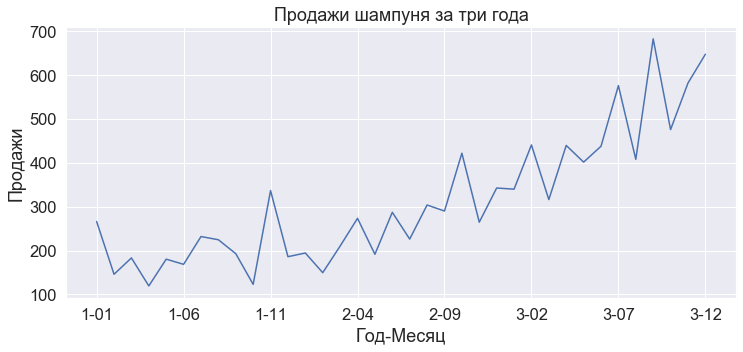

In [55]:
sns.set(style='darkgrid', font_scale=1.5)
plt.figure(figsize=(12, 5))
plt.plot(data['Month'], data['Sales'])
plt.xticks(data['Month'][::5])
plt.title('Продажи шампуня за три года')
plt.xlabel('Год-Месяц')
plt.ylabel('Продажи')
plt.show()

Из графика видно, что продажи в определенный день сильно связаны с соседними днями. При обычной кросс-валидации возникнет ситуация "заглядывания в будущее". Например, если фолды для обучения будут состоять из объектов за первый и третий года, а тестовый фолд будет состоять из объектов за второй год. Тогда на кросс-валидации будет оцениваться модель, у которой уже есть информация о будущем. В реальности мы не сможем применить такую модель, ведь мы все же хотим предсказывать информацию о будущих продажах.

В данной ситуации на помощь нам приходит `TimeSeriesSplit`. Данная техника кросс-валидации заключается в следующем: данные делятся на $K$ фолдов, затем модель обучается на первых $k$ фолдах и ее качество оценивается на $k+1$ фолде. При таком подходе заглядывания в будущее не возникает. Визуализация:

![Time Series CV](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0101.png)

Пример использования:

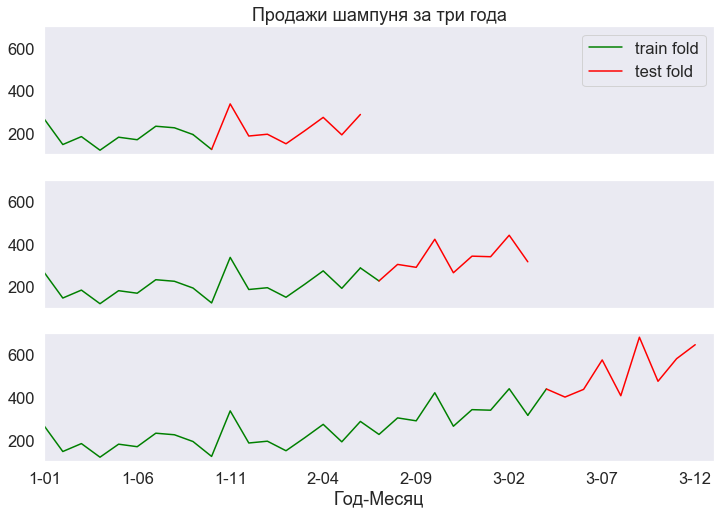

In [108]:
tscv = TimeSeriesSplit(n_splits=3)  # n_splits - количество итераций

num = 1  # номер графика

sns.set(style='dark', font_scale=1.5)
plt.figure(figsize=(12,8))
for train, test in tscv.split(data):
    plt.subplot(3, 1, num)
    plt.plot(data['Month'][train], data['Sales'][train], 
             label='train fold', color='green')
   
    plt.plot((data['Month'][train].shape[0] - 1, 
              data['Month'][train].shape[0]), 
             (data['Sales'][train].iloc[-1], 
              data['Sales'][test].iloc[0]), 
             color='green')

    plt.plot(data['Month'][test], data['Sales'][test], 
             label='test fold', color='red')
    if num < 3:
        plt.tick_params(axis='x', which='both', 
                        bottom=False, top=False, labelbottom=False)
    else:
        plt.xlabel('Год-Месяц')
        plt.xticks(data['Month'][::5])
    plt.xlim(0, data.shape[0])
    plt.ylim(100, 700)
    if num == 1:
        plt.title('Продажи шампуня за три года')
        plt.legend()
    
    num += 1

### Итоги ###

Итак, выше мы рассмотрели множество стратегий кросс-валидации и узнали, в каких случаях какой из них отдавать предпочтение. О том, как использовать кросс-валидацию при настройке гиперпараметров модели, вы узнаете в ноутбуке "Настройка гиперпараметров". В качестве итога можно сказать, что кросс-валидация - это отличный метод для оценки качества вашей модели, потому что при обучении вы можете задействовать все имеющиеся данные. К сожалению, его немаловажным минусом является количество процедур обучения - часто требуется большое количество вычислительных мощностей, особенно если вы работаете с большими датасетами.